# Reservoir Simulation
### Notebook for simulating paths based on the reservoir computing technique

Code based on: https://gist.github.com/jteichma/2027350d66545a45caa6aea7ef5a8ae4

In [1]:
!mkdir ./resssim

In [2]:
!pip install yfinance

  Preparing metadata (setup.py) ... - done
  Created wheel for multitasking: filename=multitasking-0.0.10-py3-none-any.whl size=8500 sha256=dd091b6720912498e07d2c87ffbb351c50279893900b7298c7b113d676965e82
  Stored in directory: /root/.cache/pip/wheels/34/ba/79/c0260c6f1a03f420ec7673eff9981778f293b9107974679e36
Successfully built multitasking


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import yfinance as yf
import statsmodels.api as sm
import pylab

from sklearn.linear_model import Ridge

In [4]:
ticker = yf.Ticker('^GSPC')
path = ticker.history(start='2013-03-04', end='2018-01-02').Close
path = path / path[0]
path = pd.Series(path)

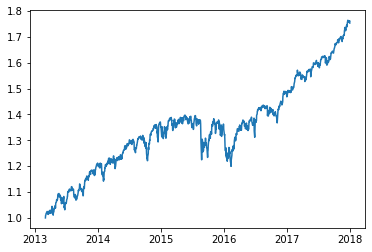

In [5]:
plt.plot(path)

In [6]:
# Constructing the random signal from the true paths

lrets = np.log(path/path.shift(1)).dropna()
var = lrets.rolling(30).cov().dropna()
std = np.sqrt(var)
inv_std = 1 / std

dates = lrets.index
dates = dates[30:]

inv_std = inv_std[dates]
lrets = lrets[dates]

market_bm_incs = lrets * inv_std  # this is the random signal that underlies the market paths

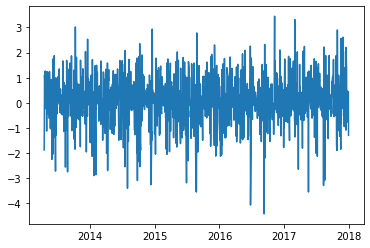

In [7]:
plt.plot(market_bm_incs)

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


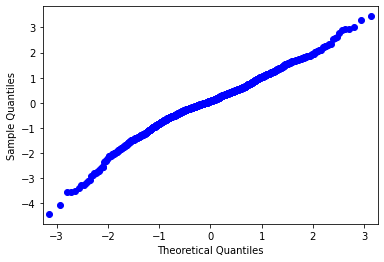

In [8]:
sm.qqplot(market_bm_incs);

In [9]:
M = 150 ## dimension of the reservoir

# random matrices for the differential equation
A = np.random.normal(0.0,0.03,size=(M,M))
beta = np.random.normal(0.0,0.03,size=(M))

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [11]:
def res_path_inc(res_path, bm_inc):
    return sigmoid(A @ res_path + beta) * bm_inc

In [12]:
def reservoir(bm_incs):
    res_path = np.zeros([len(bm_incs) + 1, M])
    res_path[0, 0] = 1.0
    
    for i, inc in enumerate(bm_incs):
        res_inc = res_path_inc(res_path[i], inc)
        res_path[i+1] = res_path[i] + res_inc
    
    return res_path

In [13]:
x = reservoir(market_bm_incs)  # input to the readout map
y = path[30:]  # target of the readout

In [14]:
# fitting the readout map as linear regression

model = Ridge(alpha=1.0)
model.fit(x, y)

Ridge()

In [15]:
model.score(x, y)

0.9991067443954734

In [16]:
def simulate(batch_size, path_length=30):

    sim_bm_incs = np.random.normal(loc=0, scale=1, size=(batch_size, path_length))
    sim_paths = []

    for sim_bm_inc in sim_bm_incs:
        x = reservoir(sim_bm_inc)
        sim_path = model.predict(x)
        sim_path = sim_path / sim_path[0]
        sim_paths.append(sim_path)
    
    return np.array(sim_paths)

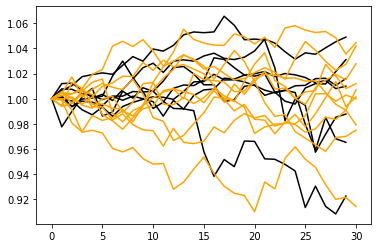

In [17]:
# Plot to compare with true future paths

fut = ticker.history(start='2018-01-02', end='2019-01-02').Close
m = np.floor(len(fut) / 30)
real_example_paths = []

for i in np.arange(start=0, stop=(m-1)*30, step=30):
    i = int(i)
    path = fut.iloc[i:i+30].values
    path = path / path[0]
    real_example_paths.append(path)

sim_paths = simulate(10)    

plt.plot(np.array(real_example_paths).T, c='black');
plt.plot(np.array(sim_paths).T, c='orange');

In [18]:
from tqdm import trange

N_BATCHES = 1000
BATCH_SIZE = 256

for i in trange(N_BATCHES):
    paths = simulate(BATCH_SIZE)
    df = pd.DataFrame(paths)
    df.columns = df.columns.astype(str)
    fname = f"./resssim/respath{i}.parquet"
    df.to_parquet(fname)

100%|██████████| 1000/1000 [07:27<00:00,  2.24it/s]


## Making some plots for the paper

In [19]:
sim_bm_incs = np.random.normal(loc=0, scale=1, size=(1, 100))
sim_paths = []

for sim_bm_inc in sim_bm_incs:
    x = reservoir(sim_bm_inc)
    sim_path = model.predict(x)
    sim_path = sim_path / sim_path[0]
    sim_paths.append(sim_path)

sim_paths = np.array(sim_paths)

In [20]:
import matplotlib as mpl
s = mpl.rcParams['figure.figsize']

In [21]:
plt.style.use('default')
mpl.rcParams['figure.figsize'] = (np.array(s) * 0.5).tolist()

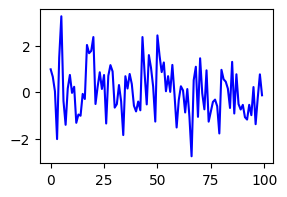

In [22]:
plt.plot(sim_bm_incs.T, c='blue');

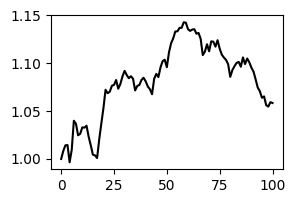

In [23]:
plt.plot(sim_paths.T, c='black');

In [24]:
idx = np.random.choice(np.arange(M), size=10)

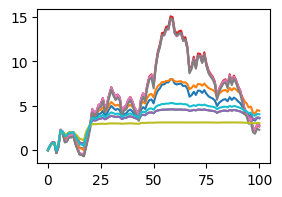

In [25]:
plt.plot(x.T[idx].T);